# Introduction to Python Multithreading and Multiprocessing

[Intro to Threads and Processes in Python](https://medium.com/@bfortuner/python-multithreading-vs-multiprocessing-73072ce5600b)


## What is parallel processing?

Doing two things at the same time, either running code simultaneously on different CPUs, or running code on the same CPU and achieving speedups by taking advantage of "wasted" CPU cycles while your program is waiting for external resources -- file loading, API calls.


In [1]:
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import numpy as np
import time
import matplotlib.pyplot as plt
import glob
from PIL import Image
import random
import string
%matplotlib inline

In [2]:
MULTITHREADING_TITLE="Multithreading"
MULTIPROCESSING_TITLE="Multiprocessing"

def visualize_runtimes(results, title):
    start,stop = np.array(results).T
    plt.barh(range(len(start)),stop-start,left=start)
    plt.grid(axis='x')
    plt.ylabel("Tasks")
    plt.xlabel("Seconds")
    plt.title(title)
    return stop[-1]-start[0]

In [3]:
def multithreading(func, args, workers):
    begin_time = time.time()
    with ThreadPoolExecutor(max_workers=workers) as executor:
        res = executor.map(func, args, [begin_time for i in range(len(args))])  # input [] and [] (url, base)
    return list(res)
        
def multiprocessing(func, args, workers):
    begin_time = time.time()
    with ProcessPoolExecutor(max_workers=workers) as executor:
        res = executor.map(func, args, [begin_time for i in range(len(args))])
    return list(res)

### API Calls

In [4]:
from urllib.request import urlopen

def download(url, base):
    start = time.time() - base
    try:
        resp = urlopen(url)
    except Exception as e:
        print ('ERROR: %s' % e)
    stop = time.time() - base
    return start, stop

In [5]:
N = 16
URL = 'http://scholar.princeton.edu/sites/default/files/oversize_pdf_test_0.pdf'
urls = [URL for i in range(N)]

#### Serial

In [6]:
%timeit -n 1 [download(url, 1) for url in urls]

20 s ± 105 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Multithreading

19.920491456985474

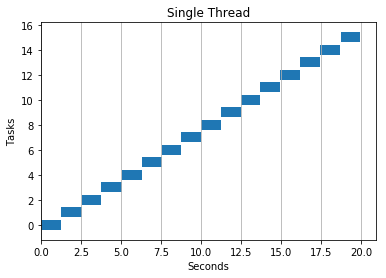

In [7]:
visualize_runtimes(multithreading(download, urls, 1), "Single Thread")

10.066268920898438

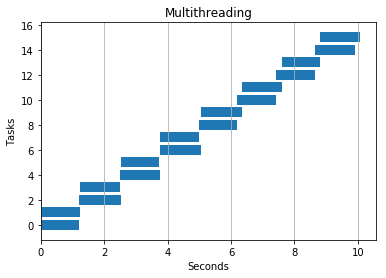

In [8]:
visualize_runtimes(multithreading(download, urls, 2),MULTITHREADING_TITLE)

5.69273567199707

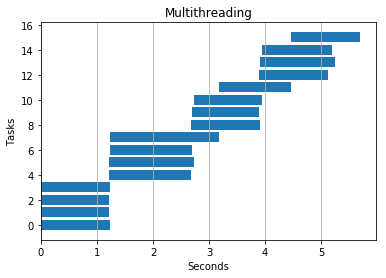

In [9]:
visualize_runtimes(multithreading(download, urls, 4),MULTITHREADING_TITLE)

#### Multiprocessing

20.062756061553955

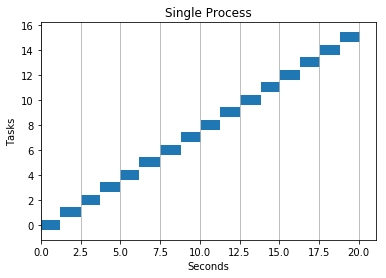

In [10]:
visualize_runtimes(multiprocessing(download, urls, 1), "Single Process")

9.988622426986694

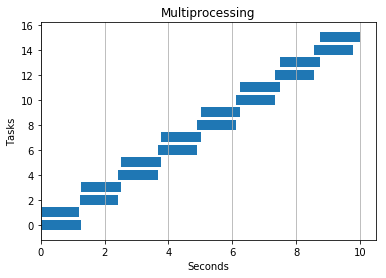

In [11]:
visualize_runtimes(multiprocessing(download, urls, 2), MULTIPROCESSING_TITLE)

5.245351552963257

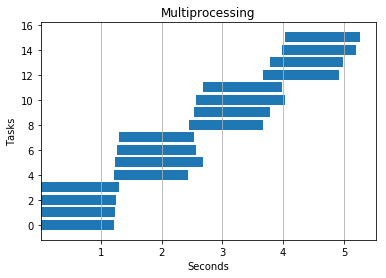

In [12]:
visualize_runtimes(multiprocessing(download, urls, 4), MULTIPROCESSING_TITLE)

## Process vs. Thread

- Process:
    - instance of program
    - process spwan threads (sub-processes) to handle subtasks like reading, keystrokes, loading HTML pages, saving files.
    - threads live inside processes and share the same memory space
    - processes has more overhead than threads as opening and closing processes takes more time
    - Sharing information between processes is slower than sharing between threads as processes do not share memory space. In python they share information by picking data structures like arrays which require IO time.
    
- Thread:
    - Threads are like mini-processes that live inside a process
    - They share memory space and efficiently read and write to the same variables
    - Two threads cannot execute code simultaneously in the same python program (although there are workarounds)


## Python's GIL problem

CPython (the standard python implementation) has something called the GIL (Global Interpreter Lock), which prevent two threads from executing simultaneously in the same program.
Some people are upset by this, while others fiercely defend it.
There are workarounds, however, and libraries like Numpy bypass this limitation by running external code in C.

## When to use threads vs processes?

- Processes speeed up Python operations taht are CPU intensive because they benefit from multiple cores and avoid the GIL
- Threads are best for IO tasks or tasks involving external systems because threads can combine their work more efficiently. Processes need to pickle their results to combine them which takes time.
- Threads provide no benefit in python for CPU intensive tasks because of the GIL (other than Numpy functions)

## CPU Intensive

In [13]:
def cpu_heavy(n,base):
    start = time.time() - base
    count = 0
    for i in range(n):
        count += i
    stop = time.time() - base
    return start,stop

In [14]:
N = 10**7
ITERS = 10

#### Serial

In [15]:
%timeit -n 1 [cpu_heavy(N, time.time()) for i in range(ITERS)]

3.14 s ± 23.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Multithreading

3.259289503097534

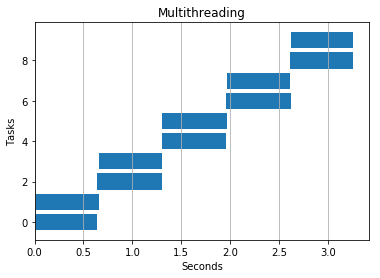

In [16]:
visualize_runtimes(multithreading(cpu_heavy, [N for i in range(ITERS)], 2),MULTITHREADING_TITLE)

3.330411434173584

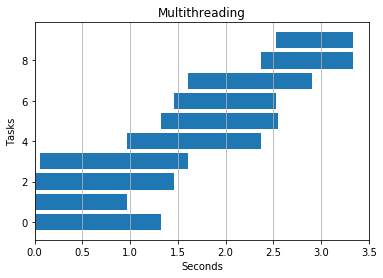

In [17]:
visualize_runtimes(multithreading(cpu_heavy, [N for i in range(ITERS)], 4),MULTITHREADING_TITLE)

#### Multiprocessing

1.595165729522705

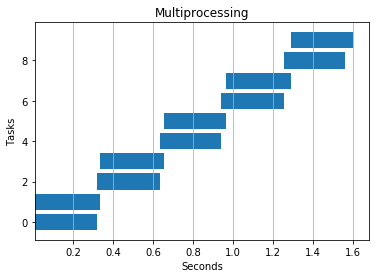

In [18]:
visualize_runtimes(multiprocessing(cpu_heavy, [N for i in range(ITERS)], 2),MULTIPROCESSING_TITLE)

0.9576568603515625

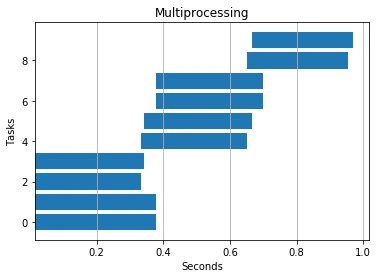

In [19]:
visualize_runtimes(multiprocessing(cpu_heavy, [N for i in range(ITERS)], 4),MULTIPROCESSING_TITLE)

## Notes:

https://en.wikipedia.org/wiki/Amdahl%27s_law

Amdah's law: Speed up in latency of a task at fixed workload that can be expected of a system whose resources are improved.

https://nathangrigg.com/2015/04/python-threading-vs-processes

Illustrating Python Multithraeding vs Multiprocessing

https://stackoverflow.com/questions/1718465/optimal-number-of-threads-per-core/10670440#10670440

One thread per core works the best

